In [1]:
# this section imports stuff 
import pandas as pd
import numpy as np
import pystan
import matplotlib.pyplot as plt
import seaborn as sns
from pystan import StanModel
import arviz as az
from platform import python_version
import matplotlib.pyplot as plt
from orbit.utils.simulation import make_regression

In [2]:
%matplotlib inline

In [3]:
# check the things!
print('pandas: {}'.format(pd.__version__))
print('numpy: {}'.format(np.__version__))
print('pystan: {}'.format(pystan.__version__))
print(python_version())

pandas: 1.3.5
numpy: 1.21.4
pystan: 2.19.1.1
3.7.12


<class 'numpy.ndarray'>


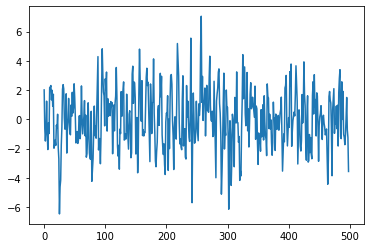

In [24]:
# make the data
n = 8736 # hourly for 1 year 

x0 = np.random.normal(0, 1, n)
x1 = np.random.normal(0, 1, n)
x2 = np.random.normal(0, 1, n)
x3 = np.random.normal(0, 1, n)
x4 = np.random.normal(0, 1, n)
x5 = np.random.normal(0, 1, n)
x6 = np.random.normal(0, 1, n)
x7 = np.random.normal(0, 1, n)
x8 = np.random.normal(0, 1, n)
x9 = np.random.normal(0, 1, n)

X = np.vstack([x0, x1]).transpose()
   
    

eta = np.random.normal(0, 1, n)
rho = [0.45, -0.25, 0.25]
beta = [1.00, -1.00]
y = eta.copy()
for i in range(2, n):
    y[i] = rho[0]*y[i-1] + rho[1]*y[i-24] + rho[2]*y[i-168] + x0[i]*beta[0]+ x1[i]*beta[1]+ eta[i]

    
    
#plt.plot(y)
plt.plot(y[1:500])
print(type(X))

In [ ]:
X[:,1:2]

In [30]:
model_code = """
    data {
      int<lower=0> P;
      int<lower=0> Q;
      int<lower=0> K;
      int<lower=0> N;
      matrix[N, K] X;
      real t_star;
      real y[N]; 
      // to avoid having to do every lag 
      int lag_ar[P]; 
      int lag_ma[Q];
      int lm_first; 

    }
    
    transformed data {
    real watanabe_beta;
    watanabe_beta = 1.0/t_star; // the sampling temp  
    }
    
    parameters {
      real mu;
      real<lower=-1,upper=1> rho[P];
      real<lower=-1,upper=1> theta[Q];
      real<lower=0> sigma;
      real beta[K];
    }
    
    transformed parameters {
        vector[N] yhat;  // full prediction
        vector[N] log_p; // log prob of each observation
        vector[N] err;   // error for time t for the MA model
        vector[N] resid; // the residual of the linear model
        vector[N] lhat;  // the prediction of the linear model
        vector[N] arhat; // the prediction of the AR model 
        vector[N] mahat; // the prediction of the MA  
        for (i in 1:N) {
            // initialize all the contributions 
            arhat[i] = 0; 
            mahat[i] = 0; 
            lhat[i] = mu; // add the constant
            for (k in 1:K) { // additional regressors 
              lhat[i] += beta[k]*X[i,k];
              }
            // lm_first = 1 means resid = y - X beta
            // lm_first = 0 means resid = y
            resid[i] = y[i] - lm_first*lhat[i]; // get the residuals from the linear model
            
            for (p in 1:P) {  // add in the ar terms 
              if ( i > lag_ar[p] ) {
                  arhat[i] += rho[p] * resid[i-lag_ar[p]];
                  }
              }
            for (q in 1:Q) { // add in the MA terms 
              if ( i > lag_ma[q] ) {
                  mahat[i] += theta[q]*err[i-lag_ma[q]] ;
                  }
              }
            // 
            
            // lm_first = 1 means error = 0 - ar - ma (1-lm_first = 0)
            // lm_first = 0 means resid = y - yhat = y - lm - ar - ma (1-lm_first = 1)
            err[i] = (1-lm_first)*y[i] - (1-lm_first)*lhat[i] - arhat[i] - mahat[i]; // get the error 
            
            yhat[i] = lhat[i] + arhat[i] + mahat[i]; // the full prediction

            log_p[i] = normal_lpdf(y[i]|yhat[i], sigma); // the log probs 
            }
    }
    
    
    model {
      
      for (i in 1:N) 
        target += watanabe_beta*log_p[i];
      
    }"""
ARMA_P_Q = StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ea35d47c3fcbbdd7f09d353be4042ab3 NOW.
In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_zdjd7hsm/stanfit4anon_model_ea35d47c3fcbbdd7f09d353be4042ab3_8200512742494903387.cpp:771:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969:
/Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it wit

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_zdjd7hsm/stanfit4anon_model_ea35d47c3fcbbdd7f09d353be4042ab3_8200512742494903387.cpp:780:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_zdjd7hsm/stanfit4anon_model_ea35d47c3fcbbdd7f09d353be4042ab3_8200512742494903387.cpp:780:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_zdjd7hsm/stanfit4anon_model_ea35d47c3fcbbdd7f09d353be4042ab3_8200512742494903387.cpp:781:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan_fit.hpp:15:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/additive_combine.hpp:27:
/Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:140:20: warning: overlapping comparisons always evaluate to false [-Wtautological-overlap-compare]
        if(_x <= 0 && _x != 0) {
           ~~~~~~~~^~~~~~~~~~
/Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:393:11: note: in instantiation of member function 'boost::ran

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_zdjd7hsm/stanfit4anon_model_ea35d47c3fcbbdd7f09d353be4042ab3_8200512742494903387.cpp:780:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_zdjd7hsm/stanfit4anon_model_ea35d47c3fcbbdd7f09d353be4042ab3_8200512742494903387.cpp:780:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_zdjd7hsm/stanfit4anon_model_ea35d47c3fcbbdd7f09d353be4042ab3_8200512742494903387.cpp:780:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages

  call_assignment(dst, src, internal::assign_op<typename Dst::Scalar,typename Src::Scalar>());
  ^
/Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Eigenvalues/./Tridiagonalization.h:445:5: note: in instantiation of function template specialization 'Eigen::internal::tridiagonalization_inplace<Eigen::Matrix<double, -1, -1, 0>, Eigen::Matrix<double, -1, 1, 0>>' requested here
    tridiagonalization_inplace(mat,hCoeffs);
    ^
/Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Eigenvalues/./Tridiagonalization.h:430:52: note: in instantiation of function template specialization 'Eigen::internal::tridiagonalization_inplace_selector<Eigen::Matrix<double, -1, -1, 0>, -1, false>::run<Eigen::Matrix<double, -1, 1, 0>, Eigen::Matrix<double, -1, 1, 0>>' requested here
  tridiagonalization_inplace_selector<MatrixType>::run(mat, diag, subdiag, extr

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_zdjd7hsm/stanfit4anon_model_ea35d47c3fcbbdd7f09d353be4042ab3_8200512742494903387.cpp:780:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_zdjd7hsm/stanfit4anon_model_ea35d47c3fcbbdd7f09d353be4042ab3_8200512742494903387.cpp:780:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_zdjd7hsm/stanfit4anon_model_ea35d47c3fcbbdd7f09d353be4042ab3_8200512742494903387.cpp:780:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_zdjd7hsm/stanfit4anon_model_ea35d47c3fcbbdd7f09d353be4042ab3_8200512742494903387.cpp:780:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_zdjd7hsm/stanfit4anon_model_ea35d47c3fcbbdd7f09d353be4042ab3_8200512742494903387.cpp:780:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages

152 warnings generated.


In [35]:
data = {
    'N': len(y),
    'P': 3, # number of AR terms 
    'Q': 0, # number of MA terms 
    'K': 2, # number of linear regressors 
    'X': X, # linear design matrix 
    'y': y, # response 
    't_star' : 1.0,
    'lag_ar': np.asarray([1,24,168], dtype=np.int32),
    'lag_ma': np.asarray([], dtype=np.int32),
    'lm_first' : 0,
}
fit_ARMA_P_Q = ARMA_P_Q.sampling(data=data, iter=2000, chains=4, verbose =False)
posteriors_fit_ARMA_P_Q = fit_ARMA_P_Q.extract(permuted=True) 
print(posteriors_fit_ARMA_P_Q.keys())


Gradient evaluation took 0.009786 seconds
1000 transitions using 10 leapfrog steps per transition would take 97.86 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.011548 seconds
1000 transitions using 10 leapfrog steps per transition would take 115.48 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.00853 seconds
1000 transitions using 10 leapfrog steps per transition would take 85.3 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.012844 seconds
1000 transitions using 10 leapfrog steps per transition would take 128.44 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 68)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 68)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the 

Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


odict_keys(['mu', 'rho', 'sigma', 'beta', 'yhat', 'log_p', 'err', 'resid', 'lhat', 'arhat', 'mahat', 'lp__'])


In [41]:
posteriors_fit_ARMA_P_Q['resid']

array([[-0.32789938,  2.01033929, -0.63421331, ..., -5.83220116,
        -4.49664074, -0.7871159 ],
       [-0.32789938,  2.01033929, -0.63421331, ..., -5.83220116,
        -4.49664074, -0.7871159 ],
       [-0.32789938,  2.01033929, -0.63421331, ..., -5.83220116,
        -4.49664074, -0.7871159 ],
       ...,
       [-0.32789938,  2.01033929, -0.63421331, ..., -5.83220116,
        -4.49664074, -0.7871159 ],
       [-0.32789938,  2.01033929, -0.63421331, ..., -5.83220116,
        -4.49664074, -0.7871159 ],
       [-0.32789938,  2.01033929, -0.63421331, ..., -5.83220116,
        -4.49664074, -0.7871159 ]])

The above should show that the 2nd iteration is best 